In [15]:
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter, MultipleLocator
import mpl_axes_aligner
import datetime
import numpy as np
import scipy
from scipy.optimize import minimize
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO

In [2]:
def align_yaxis(ax1, v1, ax2, v2):
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

In [3]:
provinces=['Eastern Cape','Free State','Gauteng','KwaZulu-Natal','Limpopo','Mpumalanga','North West','Northern Cape','Western Cape']
headings=['Facilities Reporting','Admissions to Date','Died to Date','Discharged to Date','Currently Admitted','Currently in ICU','Currently Ventilated','Currently Oxygenated','Admissions in Previous Day']

<Figure size 432x288 with 0 Axes>

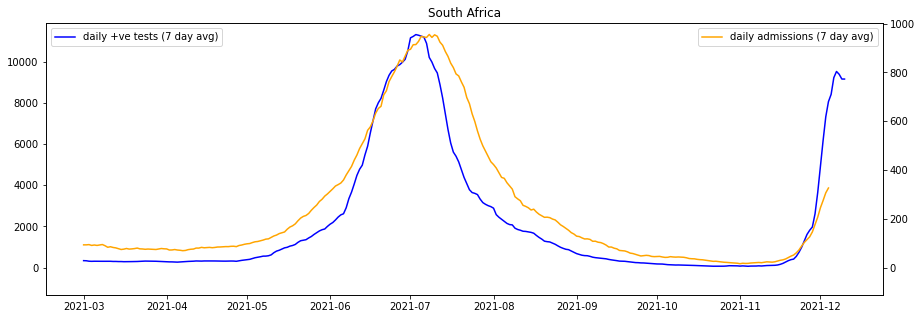

<Figure size 432x288 with 0 Axes>

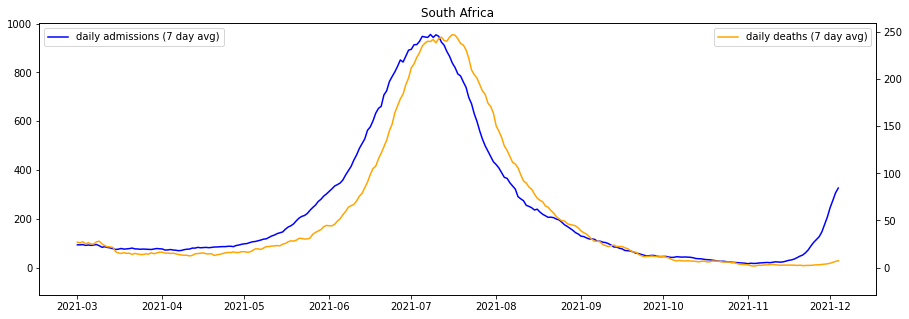

In [16]:
xs = []
y_test = []
y_admiss = []
y_died = []

startDate = datetime.datetime(2021,3,1)

with open('ts.csv', 'r') as f:
    csv_reader = csv.reader(f)
    next(csv_reader)
    for row in csv_reader:
        date = row[0]
        x_date = datetime.datetime.strptime(date, '%d/%m/%Y')
        if x_date < startDate:
            continue
        xs.append(x_date)
        y_test.append(float(row[1]) if row[1] else np.nan)
        y_admiss.append(float(row[2]) if row[2] else np.nan)
        y_died.append(float(row[3]) if row[3] else np.nan)
    
y_test = np.array(y_test)
y_admiss = np.array(y_admiss)
y_died = np.array(y_died)

plt.clf()
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
ax2 = ax1.twinx()
ax1.plot(xs, y_test, label="daily +ve tests (7 day avg)", color="blue")
ax2.plot(xs, y_admiss, label="daily admissions (7 day avg)", color="orange")
plt.title("South Africa")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
mpl_axes_aligner.align.yaxes(ax1, 0, ax2, 0, 0.1)
#plt.savefig("SA_raw.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
ax2 = ax1.twinx()
ax1.plot(xs, y_admiss, label="daily admissions (7 day avg)", color="blue")
ax2.plot(xs, y_died, label="daily deaths (7 day avg)", color="orange")
plt.title("South Africa")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
mpl_axes_aligner.align.yaxes(ax1, 0, ax2, 0, 0.1)
#plt.savefig("SA_raw.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

In [5]:
def _f(conv, in_stream, out_stream):
    target_out_stream = out_stream[len(conv)-1:]
    pred_out_stream = np.convolve(in_stream, conv, mode="valid")
    return target_out_stream, pred_out_stream

def f(convs):
    startDate = xs[0]
    startPos = list(xs).index(startDate)
    endDate = datetime.datetime(2021, 9, 20)
    endPos = list(xs).index(endDate)
    in_stream = y_test[startPos:endPos]  
    out_stream = y_admiss[startPos:endPos]
    ret = np.zeros(np.shape(convs)[0])
    for i in range(len(ret)):
        conv = convs[i,:]
        target_out_stream, pred_out_stream = _f(conv, in_stream, out_stream)
        ret[i] = np.linalg.norm(pred_out_stream - target_out_stream, ord=1) / len(pred_out_stream)
        ret[i] += 1e4*abs(1-np.sum(conv)) if np.sum(conv)>1 else 0
    return ret    

In [6]:
n_dim = 30
n_particles = 2000

x_max = 0.1*np.ones(n_dim)
x_min = -0.01*np.ones(n_dim)
options = {'c1': 0.3, 'c2': 0.1, 'w': 0.9}
bounds = (x_min, x_max)
#init_pos = np.array([0*x_min for i in range(n_particles)])
init_pos = None

outputs = []

for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 1000, verbose=True, n_processes=11)
    outputs.append(pos)
test_admiss_kernel_raw = np.array(outputs)



2021-12-13 13:45:41,726 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.3, 'c2': 0.1, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=59.6 
2021-12-13 13:45:54,952 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 59.58008927332796, best pos: [ 1.70094258e-02  7.47846379e-03  3.16497226e-03  2.20753910e-02
  2.75449972e-03 -6.26758891e-03  1.14926470e-02  9.19507876e-03
  1.98536351e-02 -6.81140844e-04  4.82440895e-03 -2.94788459e-03
  6.64975422e-03 -4.60435693e-03  6.84834606e-03 -7.57822850e-03
  1.92813914e-02 -5.28664360e-03 -3.36322651e-03 -1.76817246e-03
 -4.15504534e-03  2.97668815e-03  4.96753844e-03 -3.31351764e-03
 -1.56726164e-05 -3.31543112e-03 -3.26060911e-03 -2.91607252e-03
  2.25564210e-02 -5.43861341e-03]
2021-12-13 13:45:54,963 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.3, 'c2': 0.1, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_c

2021-12-13 13:48:00,190 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.3, 'c2': 0.1, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=60.6 
2021-12-13 13:48:12,357 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60.5609845553289, best pos: [ 1.76940456e-03  1.97858307e-02  3.29750594e-03  1.01011901e-02
  9.21018034e-03  1.57146501e-02  4.67068449e-03  1.52555960e-03
  9.37114497e-03  7.54917027e-03  1.18651363e-03 -7.81370623e-04
 -2.47901396e-03  7.71524088e-05  4.45515309e-03  4.81363990e-03
  8.37221413e-03  3.95453044e-03  4.08719847e-03 -9.35931282e-03
 -9.37220417e-03  1.67151193e-03  1.25365805e-03  1.81252978e-04
 -3.73625575e-03  2.29930882e-03 -5.77890935e-03  2.78805334e-03
 -6.30989101e-03  2.40192507e-02]
2021-12-13 13:48:12,366 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.3, 'c2': 0.1, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_co

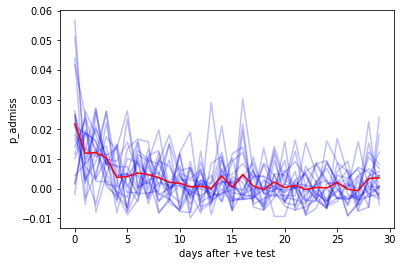

0.10604238942844249


In [7]:
plt.clf()
x = list(range(len(pos)))
for v in test_admiss_kernel_raw:
    plt.plot(x, v, color="blue", alpha=0.25)
test_admiss_kernel = []
for i in range(len(v)):
    test_admiss_kernel.append(np.mean(test_admiss_kernel_raw[:,i]))
plt.plot(x, test_admiss_kernel, color="red", alpha=1)
plt.xlabel("days after +ve test")
plt.ylabel("p_admiss")
plt.savefig("convolution.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

print(np.sum(test_admiss_kernel))

<Figure size 432x288 with 0 Axes>

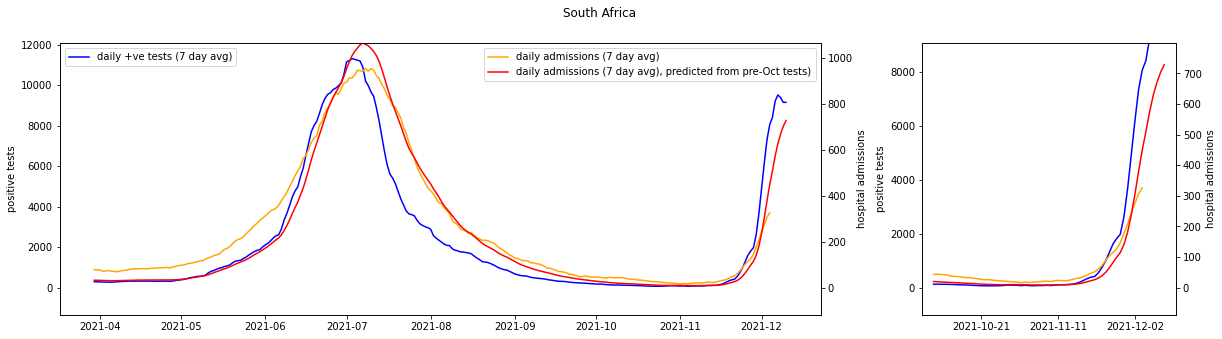

In [14]:
def diff_axis(scale, ax1, ax2):
    _,l1 = ax1.get_ylim()
    _,l2 = ax2.get_ylim()
    d1 = np.array(ax1.lines[0].get_ydata())
    d2 = np.array(ax2.lines[0].get_ydata())
    d1 = np.nan_to_num(d1,0)
    d2 = np.nan_to_num(d2,0)
    return np.mean(np.abs(d1/scale-d2))
    
def match_axis(ax1, ax2):
    scale = scipy.optimize.minimize(diff_axis, 1, args=(ax1,ax2))
    _,l2 = ax2.get_ylim()
    ax1.set_ylim(0,l2*scale.x)  
    return scale.x

plt.clf()
true, pred = _f(test_admiss_kernel, y_test, y_admiss) 
x = xs[-len(true):]

# main graph
plt.clf()
fig, axes = plt.subplots(1,2, figsize=(20,5), gridspec_kw={'width_ratios':[3,1]})
ax1,ax3 = axes
ax2 = ax1.twinx()    
ax1.plot(x, y_test[-len(true):], label="daily +ve tests (7 day avg)", color="blue")
ax2.plot(x, y_admiss[-len(true):], label="daily admissions (7 day avg)", color="orange")
ax2.set_ylim(0,np.nanmax(pred))
twinScale = match_axis(ax1, ax2)
ax2.plot(x, pred, label="daily admissions (7 day avg), predicted from pre-Oct tests)", color="red")

# zoomed in on latest
prev_days = 64
scale = prev_days / len(x) * 3 
ax4 = ax3.twinx()    
ax3.plot(x[-prev_days:], y_test[-prev_days:], color="blue")
ax4.plot(x[-prev_days:], y_admiss[-prev_days:], color="orange")
ax4.plot(x[-prev_days:], pred[-prev_days:], color="red")
ax4.set_ylim(0,np.nanmax(pred)*scale)
ax3.set_ylim(0,np.nanmax(pred)*twinScale*scale)
ax4.xaxis.set_major_locator(MultipleLocator(21)) 

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_ylabel("positive tests")
ax2.set_ylabel("hospital admissions")
ax3.set_ylabel("positive tests")
ax4.set_ylabel("hospital admissions")

mpl_axes_aligner.align.yaxes(ax1, 0, ax2, 0, 0.1)
mpl_axes_aligner.align.yaxes(ax1, 0, ax3, 0, 0.1)
mpl_axes_aligner.align.yaxes(ax1, 0, ax4, 0, 0.1)

plt.suptitle("South Africa")
plt.savefig("South Africa"+"_test_admiss_pred.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()    


In [9]:
def _g(conv, in_stream, out_stream):
    target_out_stream = out_stream[len(conv)-1:]
    pred_out_stream = np.convolve(in_stream, conv, mode="valid")
    return target_out_stream, pred_out_stream

def g(convs):
    startDate = xs[0]
    startPos = list(xs).index(startDate)
    endDate = datetime.datetime(2021, 11, 20)
    endPos = list(xs).index(endDate)
    in_stream = y_admiss[startPos:endPos]  
    out_stream = y_died[startPos:endPos]
    ret = np.zeros(np.shape(convs)[0])
    for i in range(len(ret)):
        conv = convs[i,:]
        target_out_stream, pred_out_stream = _g(conv, in_stream, out_stream)
        ret[i] = np.linalg.norm(pred_out_stream - target_out_stream, ord=1) / len(pred_out_stream)
        ret[i] += 1e4*abs(1-np.sum(conv)) if np.sum(conv)>1 else 0
    return ret    

In [10]:
n_dim = 30
n_particles = 2000

x_max = 0.1*np.ones(n_dim)
x_min = -0.01*np.ones(n_dim)
options = {'c1': 0.3, 'c2': 0.1, 'w': 0.9}
bounds = (x_min, x_max)
#init_pos = np.array([0*x_min for i in range(n_particles)])
init_pos = None

outputs = []

for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(g, 1000, verbose=True, n_processes=11)
    outputs.append(pos)
admiss_death_kernel_raw = np.array(outputs)

2021-12-13 13:49:50,835 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.3, 'c2': 0.1, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=5.63
2021-12-13 13:50:03,473 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.626793262899453, best pos: [-0.00666794  0.00612893  0.06046571  0.00744176 -0.00135771  0.00927314
 -0.00186334  0.06265019  0.00306805  0.002002    0.00869912  0.04306908
 -0.00657947  0.01964878  0.02794935  0.0316835   0.00598415  0.01949775
 -0.00691009  0.01108437 -0.00865505 -0.00751994 -0.00334563 -0.0078636
 -0.00493942  0.00111938 -0.00590314 -0.00919541  0.00052844 -0.00246422]
2021-12-13 13:50:03,482 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.3, 'c2': 0.1, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=6.13
2021-12-13 13:50:15,841 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.13182205571435, 

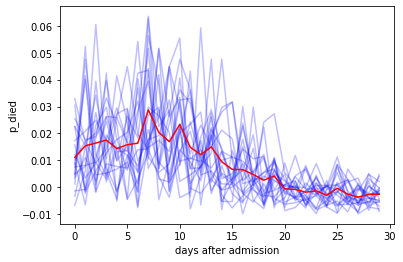

0.2533136828235407


In [11]:
plt.clf()
x = list(range(len(pos)))
for v in admiss_death_kernel_raw:
    plt.plot(x, v, color="blue", alpha=0.25)
admiss_death_kernel = []
for i in range(len(v)):
    admiss_death_kernel.append(np.mean(admiss_death_kernel_raw[:,i]))
plt.plot(x, admiss_death_kernel, color="red", alpha=1)
plt.xlabel("days after admission")
plt.ylabel("p_died")
plt.savefig("convolution.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

print(np.sum(admiss_death_kernel))

<Figure size 432x288 with 0 Axes>

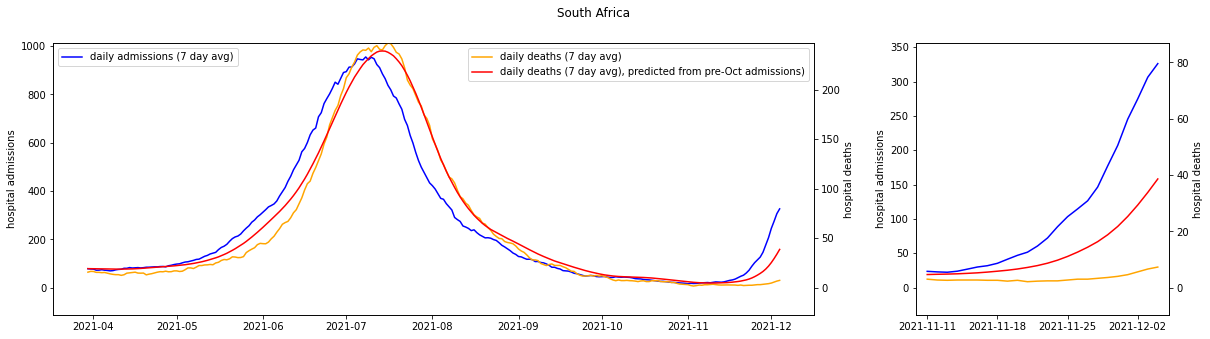

In [13]:
plt.clf()
true, pred = _g(admiss_death_kernel, y_admiss, y_died) 
x = xs[-len(true):]

# main graph
plt.clf()
fig, axes = plt.subplots(1,2, figsize=(20,5), gridspec_kw={'width_ratios':[3,1]})
ax1,ax3 = axes
ax2 = ax1.twinx()    
ax1.plot(x, y_admiss[-len(true):], label="daily admissions (7 day avg)", color="blue")
ax2.plot(x, y_died[-len(true):], label="daily deaths (7 day avg)", color="orange")
ax2.set_ylim(0,np.nanmax(y_died))
twinScale = match_axis(ax1, ax2)
ax2.plot(x, pred, label="daily deaths (7 day avg), predicted from pre-Oct admissions)", color="red")

# zoomed in on latest
prev_days = 30
scale = prev_days / len(x) * 3
ax4 = ax3.twinx()    
ax3.plot(x[-prev_days:], y_admiss[-prev_days:], color="blue")
ax4.plot(x[-prev_days:], y_died[-prev_days:], color="orange")
ax4.plot(x[-prev_days:], pred[-prev_days:], color="red")
ax4.set_ylim(0,np.nanmax(y_died)*scale)
ax3.set_ylim(0,np.nanmax(y_died)*scale * twinScale)
ax4.xaxis.set_major_locator(MultipleLocator(7)) 

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_ylabel("hospital admissions")
ax2.set_ylabel("hospital deaths")
ax3.set_ylabel("hospital admissions")
ax4.set_ylabel("hospital deaths")

mpl_axes_aligner.align.yaxes(ax1, 0, ax2, 0, 0.1)
mpl_axes_aligner.align.yaxes(ax1, 0, ax3, 0, 0.1)
mpl_axes_aligner.align.yaxes(ax1, 0, ax4, 0, 0.1)

plt.suptitle("South Africa")
plt.savefig("South Africa"+"_admiss_died_pred.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()    
